In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [246]:
df = pd.read_csv('monthly_milk_production.csv')
df

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727
...,...,...
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797


In [247]:
df.dtypes

Date          object
Production     int64
dtype: object

In [248]:
df['Date'] = pd.to_datetime(df['Date'])

In [249]:
df.dtypes

Date          datetime64[ns]
Production             int64
dtype: object

In [250]:
df.set_index('Date',inplace=True)

In [251]:
df

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


<AxesSubplot:xlabel='Date'>

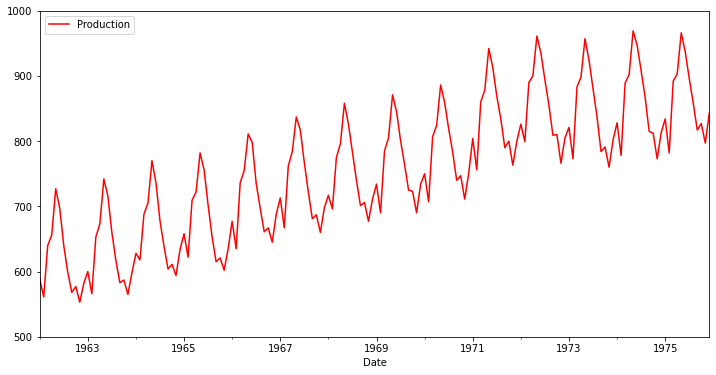

In [252]:
df.plot(ylim=[500,1000],xlim=['1962-1-1','1975-12-1'],c='red',figsize=(12,6))

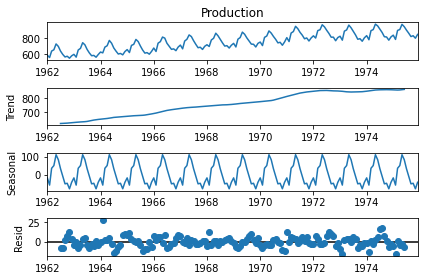

In [253]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Production'])
result.plot();

In [254]:
len(df)

168

In [255]:
train = df.iloc[0:156,:]
test = df.iloc[156:,:]

In [256]:
len(test)

12

In [257]:
#Scaling the data to mind and max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [258]:
scaler.fit(train)

MinMaxScaler()

In [259]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [260]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [261]:
#Now we find the fifth value using the first four input
from keras.preprocessing.sequence import TimeseriesGenerator
value = TimeseriesGenerator(scaled_train,scaled_train,length=4,batch_size=1)#length is the number of input for prediction the next
X,y = value[0]
print(f'The first four inputs are {X.flatten()}')
print(f'The predicted fifth output is {y.flatten()}')
print(f'Actual value is {scaled_train[4]}')
print(X.shape)

The first four inputs are [0.08653846 0.01923077 0.20913462 0.24759615]
The predicted fifth output is [0.41826923]
Actual value is [0.41826923]
(1, 4, 1)


In [262]:
#We define the model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [263]:
#for one year we define lenght as 12 n_input=12
n_input = 12
n_features=1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)
X,y = generator[0]
X.shape

(1, 12, 1)

In [264]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
     

In [265]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [266]:
 #fit model with generator defined above
model.fit(generator,epochs=50)
     

Epoch 1/50
144/144 [==============================] - 1s 3ms/step - loss: 0.0440
Epoch 2/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 3/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 4/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 7/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 8/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 9/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 10/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 11/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 12/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 13/50
144/144 [====

In [267]:
X.shape

(1, 12, 1)

In [268]:
#Taking last 12 values in the training dataset
last_train_data = scaled_train[-12:]
#reshaping the dataset to give to the model
last_train_data = last_train_data.reshape(1,n_input,n_features)


In [269]:
#predicted first test data
model.predict(last_train_data).flatten()

1/1 [==============================] - 0s 152ms/step


array([0.6569901], dtype=float32)

In [270]:
#Actual first test data
scaled_test[0]

array([0.67548077])

In [271]:

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
     

1/1 [==============================] - 0s 15ms/step


In [272]:
test_predictions

[array([0.6569901], dtype=float32),
 array([0.6387867], dtype=float32),
 array([0.8505821], dtype=float32),
 array([0.9281747], dtype=float32),
 array([1.0574269], dtype=float32),
 array([1.0351129], dtype=float32),
 array([0.9451387], dtype=float32),
 array([0.8210744], dtype=float32),
 array([0.6903369], dtype=float32),
 array([0.6347826], dtype=float32),
 array([0.57812184], dtype=float32),
 array([0.6186115], dtype=float32)]

In [273]:
prediction  = scaler.inverse_transform(test_predictions)
test['Prediction'] = prediction

C:\Users\91986\AppData\Local\Temp\ipykernel_22860\571985698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = prediction


In [274]:
test

,Production,Prediction
Date,,
1975-01-01,834,826.307886
1975-02-01,782,818.735256
1975-03-01,892,906.842163
1975-04-01,903,939.120665
1975-05-01,966,992.889603
1975-06-01,937,983.606949
1975-07-01,896,946.177696
1975-08-01,858,894.566961
1975-09-01,817,840.180143


<AxesSubplot:xlabel='Date'>

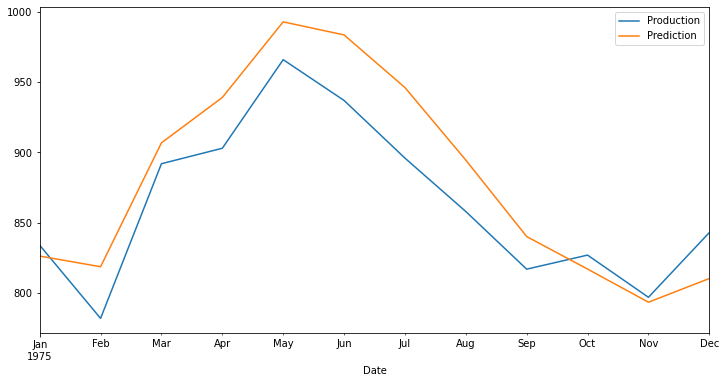

In [275]:
test.plot(xlim=['1975-1-1','1975-12-01'],figsize=(12,6))

In [276]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Prediction']))
print(rmse)

30.820114356889682


In [277]:
#Predicting the next 12days data after test dataset
test['Prediction']
scaledddd = scaler.transform(test[['Prediction']])

C:\Users\91986\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Prediction
Feature names seen at fit time, yet now missing:
- Production

  warnings.warn(message, FutureWarning)


In [278]:
test_predictions = []

first_eval_batch = scaledddd[-12:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 15ms/step


In [279]:
test_predictions

[array([0.66613394], dtype=float32),
 array([0.7122546], dtype=float32),
 array([0.90334016], dtype=float32),
 array([1.0150781], dtype=float32),
 array([1.1333402], dtype=float32),
 array([1.1307186], dtype=float32),
 array([1.040852], dtype=float32),
 array([0.89798397], dtype=float32),
 array([0.7498705], dtype=float32),
 array([0.66517574], dtype=float32),
 array([0.6134244], dtype=float32),
 array([0.62698543], dtype=float32)]

In [280]:
#rescaling
test_predictions = scaler.inverse_transform(test_predictions)
test_predictions

array([[ 830.11171913],
       [ 849.29790688],
       [ 928.78950691],
       [ 975.2724762 ],
       [1024.46953964],
       [1023.37893295],
       [ 985.99441147],
       [ 926.5613308 ],
       [ 864.94611931],
       [ 829.71310616],
       [ 808.18455887],
       [ 813.82593918]])

In [281]:
from datetime import datetime, timedelta

In [282]:
datetime(1975,12,1)+timedelta(days=1)

datetime.datetime(1975, 12, 2, 0, 0)

In [284]:
#dates after test data ends
date = pd.date_range(start='1976-01-01',periods=12,freq='MS')

In [285]:
y=pd.DataFrame(test_predictions,columns=['future'])

In [286]:
x=pd.DataFrame(date,columns=['Date'])

In [288]:
df1=pd.concat([x,y],axis=1)
df1

,Date,future
0,1976-01-01,830.111719
1,1976-02-01,849.297907
2,1976-03-01,928.789507
3,1976-04-01,975.272476
4,1976-05-01,1024.469540
5,1976-06-01,1023.378933
6,1976-07-01,985.994411
7,1976-08-01,926.561331
8,1976-09-01,864.946119
9,1976-10-01,829.713106


In [289]:
df1=df1.set_index('Date')
df1

,future
Date,
1976-01-01,830.111719
1976-02-01,849.297907
1976-03-01,928.789507
1976-04-01,975.272476
1976-05-01,1024.469540
1976-06-01,1023.378933
1976-07-01,985.994411
1976-08-01,926.561331
1976-09-01,864.946119


In [291]:
#joining the original and new dataframe
df2=pd.concat([df,df1],axis=1)
df2

,Production,future
Date,,
1962-01-01,589.0,NaN
1962-02-01,561.0,NaN
1962-03-01,640.0,NaN
1962-04-01,656.0,NaN
1962-05-01,727.0,NaN
...,...,...
1976-08-01,NaN,926.561331
1976-09-01,NaN,864.946119
1976-10-01,NaN,829.713106


<AxesSubplot:xlabel='Date'>

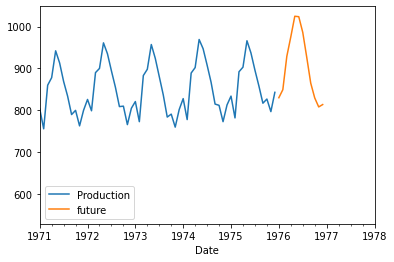

In [293]:
#Future predictions
df2.plot(xlim=['1971-01-01','1978-01-01'])